# SSIM Analysis Comparison Analysis for OOD Detection

----

### Imports and function definitions

#### Package Imports

In [1]:
import os, glob, gc, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Input, Flatten, Dense, Reshape, Dropout, BatchNormalization
from tensorflow.keras.layers import Activation, LeakyReLU, ReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

# pandas tricks for better display
pd.options.display.max_columns = 40
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

#### Navigate to `ood-detection` repository

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Replace [OOD_DETECTION_REPOSITORY] with the correct location
os.chdir('/content/drive/[OOD_DETECTION_REPOSITORY]')
!git pull

### Build Data Loaders for SSIM Analysis

In [11]:
from data_utils.datasets import find_image_files, build_dataset

# Select dataset of interest
dataset = 'bollworms' # ['bollworms', 'bollworms-clean']

# These keyword arguments will be 00s0hared by all image datasets
ds_kwargs = {'cache': True, 'image_shape': (256, 256, 3), 'batch_size': 1000, 'shuffle_buffer': 512}

# Build training sets of ID and OOD images
ID_df = find_image_files(f'data/{dataset}-train/ID')
ID_ds = build_dataset(ID_df, augment=False, shuffle=False, **ds_kwargs)
OOD_df = find_image_files(f'data/{dataset}-train/OOD')
OOD_ds = build_dataset(OOD_df, augment=False, shuffle=False, **ds_kwargs)

# Build testing sets of ID and OOD images
test_ID_df = find_image_files(f'data/{dataset}-test/ID')
test_ID_ds = build_dataset(test_ID_df, augment=False, shuffle=False, **ds_kwargs)
test_OOD_df = find_image_files(f'data/{dataset}-test/OOD')
test_OOD_ds = build_dataset(test_OOD_df, augment=False, shuffle=False, **ds_kwargs)

Found 7779 image files in folder "data/bollworms-train/ID"
Found 975 image files in folder "data/bollworms-train/OOD"
Found 865 image files in folder "data/bollworms-test/ID"
Found 108 image files in folder "data/bollworms-test/OOD"


#### Import Helper Functions

In [ ]:
from models.ssim import distribution_overlap_summary, plot_confusion_matrix, plot_SSIM_summary, logistic_regression_summary

## K-means Clustering on the ID Image Data Set

In [ ]:
ID_images = [] # Create a list to hold the ID images read in as [# imgs x 256 x 256 x 3]
gc.collect()

for (input_images, _) in ID_ds: # Iterate on the data loader to read in images
    batch_imgs = np.stack([input_images])
    batch_imgs = batch_imgs[0,:,:,:]
    batch_imgs = batch_imgs.reshape(batch_imgs.shape[0], -1)
    ID_images.append(batch_imgs)
ID_images = np.concatenate(ID_images);print(ID_images.shape) # Combine them all into 1 large np.array, [N imgs x 256x256x3]

(7779, 196608)


In [ ]:
del batch_imgs;gc.collect() # Delete objects from memory not in usage

0

In [ ]:
k = 10 # Set the number of clusters to run in k-means clustering
ID_img_k_means = KMeans(n_clusters=k);ID_img_k_means.fit(ID_images) # Fit the k-means model on the latent sapce
ID_cluster_centroids = ID_img_k_means.cluster_centers_ # Extract the fitted cluster centroids on the ID train set

In [ ]:
ID_cluster_centroids = ID_cluster_centroids.reshape([ID_cluster_centroids.shape[0]]+list(ds_kwargs["image_shape"]))
print("ID_cluster_centroids.shape",ID_cluster_centroids.shape) # Re-shape into natural image layout dimensions (256 x 256 x 3)

ID_cluster_centroids.shape (10, 256, 256, 3)


In [ ]:
if dataset == 'bollworms': # Save down the fitted cluster centroids to disk for later use (quick recall)
  np.save("notebooks/ssim_cluster_centroids/ID_cluster_centroids_bollworms_train.npy",ID_cluster_centroids)
else:
  np.save("notebooks/ssim_cluster_centroids/ID_cluster_centroids_bollworms_clean_train.npy",ID_cluster_centroids)

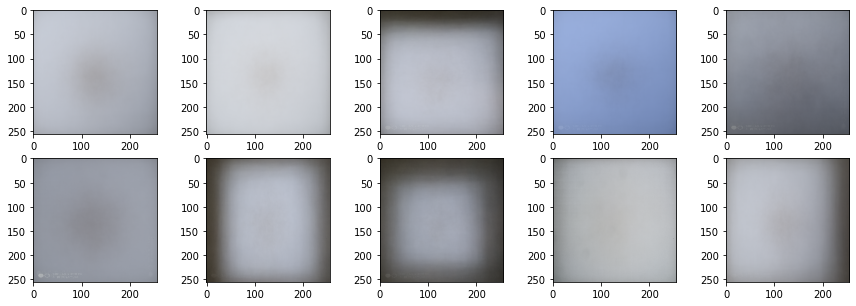

In [ ]:
# Display the ID cluster centroids visually, plot the k-means cluster centroids for this data set
fig,axes = plt.subplots(2,5,figsize=(15,5));axes=axes.reshape(-1)
for i,ax in enumerate(axes):
  ax.imshow(ID_cluster_centroids[i,:,:,:])

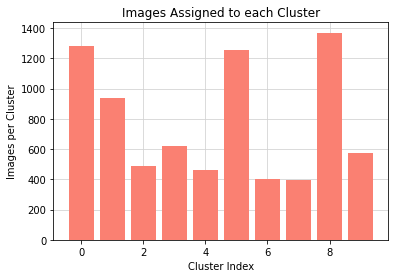

In [ ]:
# Visualize the number of images assigned to each cluster
labels, counts = np.unique(ID_img_k_means.labels_,return_counts=True)
plt.bar(x=labels,height=counts,zorder=3,color='salmon');plt.xlabel("Cluster Index");plt.ylabel("Images per Cluster");plt.grid(color='lightgray',zorder=-3)
plt.title("Images Assigned to each Cluster");plt.show()

In [ ]:
del ID_images;gc.collect() # Delete from memory what is no longer needed to reduce RAM usage

6407

In [ ]:
# Print aggregate k-means clustering model metrics
print("inertia:",ID_img_k_means.inertia_)
print("Number of iterations run:",ID_img_k_means.n_iter_)
print("Number of features used:",ID_img_k_means.n_features_in_)

inertia: 33390660.0
Number of iterations run: 57
Number of features used: 196608


## Using k-means ID image cluster centroids for SSIM image comparisons

---



In [ ]:
# Read in the saved k-means cluster centroids
if dataset == 'bollworms': # Save down the fitted cluster centroids to disk for later use (quick recall)
  ID_cluster_centroids = np.load("ood-detection/\ssim_cluster_centroids/ID_cluster_centroids_bollworms_train.npy")
else:
  ID_cluster_centroids = np.load("ood-detection/\ssim_cluster_centroids/ID_cluster_centroids_bollworms_clean_train.npy")

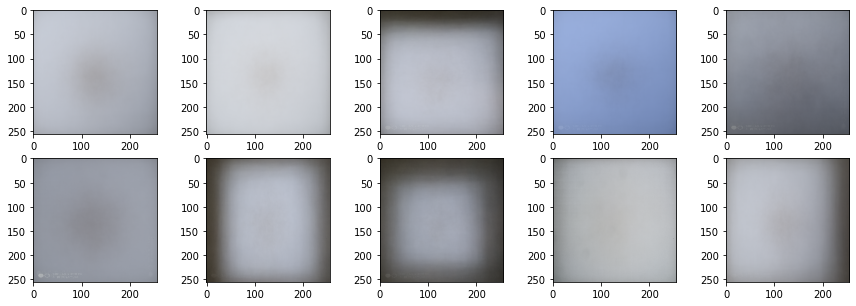

In [70]:
# Display the ID cluster centroids visually, they should exactly match the cluster centroids shown above 
fig,axes = plt.subplots(2,5,figsize=(15,5));axes=axes.reshape(-1)
for i,ax in enumerate(axes):
  ax.imshow(ID_cluster_centroids[i,:,:,:])

In [71]:
ID_image_SSIM_scores = [] # Create a list to hold the ID images read in as [# imgs x 256 x 256 x 3]
gc.collect()

for (input_images, _) in ID_ds: # Iterate on the data loader to read in images
  # Compute pairwise SSIM scores for each image in the ID and OOD training set vs each of the cluster centroids (cc)
  ID_ssim_array_cc = np.zeros([input_images.shape[0],len(ID_cluster_centroids)])

  for j,comp_img in enumerate(tqdm(ID_cluster_centroids)):
    ID_ssim_array_cc[:,j] = tf.image.ssim(input_images, comp_img, 1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

  ID_image_SSIM_scores.append(ID_ssim_array_cc)

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


In [72]:
OOD_image_SSIM_scores = [] # Create a list to hold the ID images read in as [# imgs x 256 x 256 x 3]
gc.collect()

for (input_images, _) in OOD_ds: # Iterate on the data loader to read in images
  # Compute pairwise SSIM scores for each image in the ID and OOD training set vs each of the cluster centroids (cc)
  OOD_ssim_array_cc = np.zeros([input_images.shape[0],len(ID_cluster_centroids)])

  for j,comp_img in enumerate(tqdm(ID_cluster_centroids)):
    OOD_ssim_array_cc[:,j] = tf.image.ssim(input_images, comp_img, 1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

  OOD_image_SSIM_scores.append(OOD_ssim_array_cc)

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


In [73]:
# Concatenate the resulting SSIM scores vs each cluster centroid image for all ID and OOD images in the training set into 1 aggregate vector
ID_ssim_array_cc = np.concatenate(ID_image_SSIM_scores)
OOD_ssim_array_cc = np.concatenate(OOD_image_SSIM_scores)

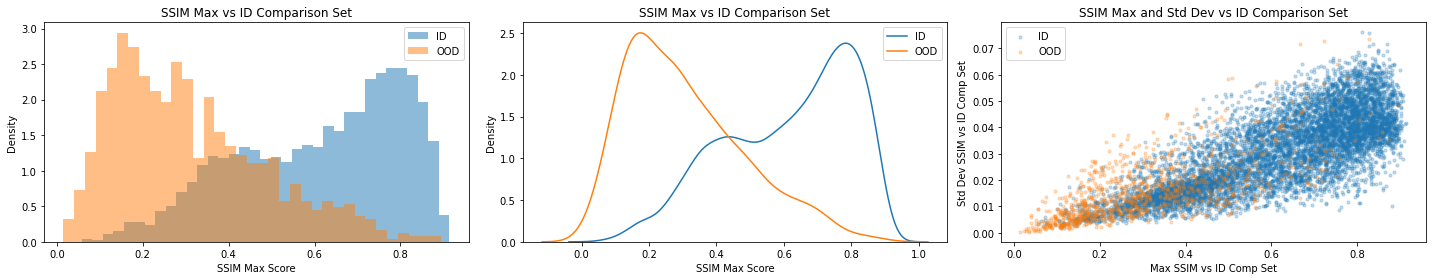

Logistic Regression Summary on SSIM Mean Values


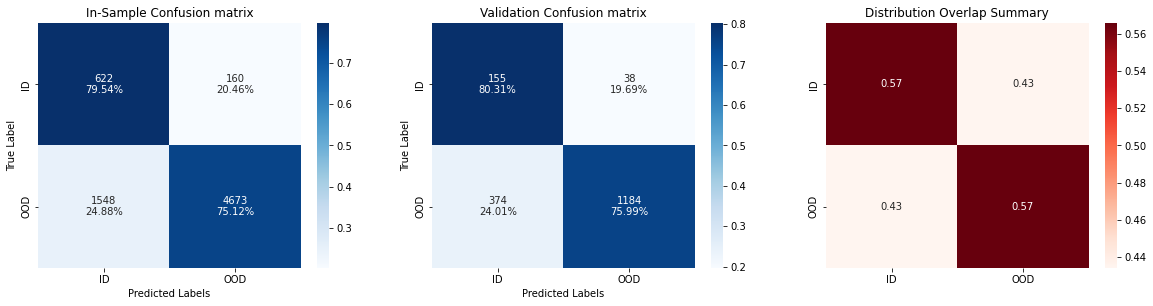

In [74]:
# Plot the SSIM scores to each of the k-means cluster centroids
ID_ssim_max = ID_ssim_array_cc.max(axis=1);OOD_ssim_max = OOD_ssim_array_cc.max(axis=1) # Save the logistic regression model we construct here for later use in the testing phase of analysis
plot_SSIM_summary(ID_ssim_array_cc, None, OOD_ssim_array_cc);SSIM_logistic_model = logistic_regression_summary(ID_ssim_max, None, OOD_ssim_max, return_model=True)

In [76]:
print(SSIM_logistic_model.coef_);print(SSIM_logistic_model.intercept_)

[[7.01796464]]
[-3.40648864]


#### Test Set Analysis

In [41]:
ID_image_SSIM_scores_test = [] # Create a list to hold the ID images read in as [# imgs x 256 x 256 x 3]
gc.collect()

for (input_images, _) in test_ID_ds: # Iterate on the data loader to read in images
  # Compute pairwise SSIM scores for each image in the ID and OOD training set vs each of the cluster centroids (cc)
  ID_ssim_array_cc = np.zeros([input_images.shape[0],len(ID_cluster_centroids)])

  for j,comp_img in enumerate(tqdm(ID_cluster_centroids)):
    ID_ssim_array_cc[:,j] = tf.image.ssim(input_images, comp_img, 1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

  ID_image_SSIM_scores_test.append(ID_ssim_array_cc)

100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


In [42]:
OOD_image_SSIM_scores_test = [] # Create a list to hold the ID images read in as [# imgs x 256 x 256 x 3]
gc.collect()

for (input_images, _) in test_OOD_ds: # Iterate on the data loader to read in images
  # Compute pairwise SSIM scores for each image in the ID and OOD training set vs each of the cluster centroids (cc)
  OOD_ssim_array_cc = np.zeros([input_images.shape[0],len(ID_cluster_centroids)])

  for j,comp_img in enumerate(tqdm(ID_cluster_centroids)):
    OOD_ssim_array_cc[:,j] = tf.image.ssim(input_images, comp_img, 1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

  OOD_image_SSIM_scores_test.append(OOD_ssim_array_cc)

100%|██████████| 10/10 [00:00<00:00, 14.99it/s]


In [45]:
# Concatenate the resulting SSIM scores vs each cluster centroid image for all ID and OOD images in the training set into 1 aggregate vector
ID_ssim_array_cc_test = np.concatenate(ID_image_SSIM_scores_test)
OOD_ssim_array_cc_test = np.concatenate(OOD_image_SSIM_scores_test)

ID_ssim_max_test = ID_ssim_array_cc_test.max(axis=1);OOD_ssim_max_test = OOD_ssim_array_cc_test.max(axis=1) # Take the max SSIM score vs the 10 cluster centroids for each image

In [47]:
# Generate predictions using the trained model on the test data set
test_set_predictions = np.concatenate([SSIM_logistic_model.predict(ID_ssim_max_test.reshape(-1,1)),SSIM_logistic_model.predict(OOD_ssim_max_test.reshape(-1,1))])
test_set_true_labels = np.concatenate([np.ones(len(ID_ssim_max_test)),np.zeros(len(OOD_ssim_max_test))])
test_set_predictions_bin = (test_set_predictions>0.5)*1 # Convert to a binary 0/1 prediction

print("Test set AUC:",round(roc_auc_score(test_set_true_labels, test_set_predictions),2))
print("Test set F1 score:",round(f1_score(test_set_true_labels, test_set_predictions_bin, average='macro'),2))
print("Test set ID Accuracy:",round((test_set_true_labels[test_set_true_labels==1] == test_set_predictions_bin[test_set_true_labels==1]).mean(),3))
print("Test set OOD Accuracy:",round((test_set_true_labels[test_set_true_labels==0] == test_set_predictions_bin[test_set_true_labels==0]).mean(),3))

Test set AUC: 0.74
Test set F1 score: 0.61
Test set ID Accuracy: 0.729
Test set OOD Accuracy: 0.75


## Full Image SSIM

---

Compute SSIM on the entire image rather than using a moving kernel

In [24]:
ID_images = [] # Create a list to hold the ID images read in as [# imgs x 256 x 256 x 3]
gc.collect()

for (input_images, _) in ID_ds: # Iterate on the data loader to read in images
  batch_imgs = np.stack([input_images])
  batch_imgs = batch_imgs[0,:,:,:]
  batch_imgs = batch_imgs.reshape(batch_imgs.shape[0], -1)
  ID_images.append(batch_imgs)

ID_images = np.concatenate(ID_images);ID_images=ID_images.reshape(-1,256,256,3);print(ID_images.shape) # Combine them all into 1 large np.array, [N imgs x 256x256x3]

(7779, 256, 256, 3)


In [25]:
OOD_images = [] # Create a list to hold the OOD images read in as [# imgs x 256 x 256 x 3]
gc.collect()

for (input_images, _) in OOD_ds: # Iterate on the data loader to read in images
  batch_imgs = np.stack([input_images])
  batch_imgs = batch_imgs[0,:,:,:]
  batch_imgs = batch_imgs.reshape(batch_imgs.shape[0], -1)
  OOD_images.append(batch_imgs)

OOD_images = np.concatenate(OOD_images);OOD_images=OOD_images.reshape(-1,256,256,3);print(OOD_images.shape) # Combine them all into 1 large np.array, [N imgs x 256x256x3]

(975, 256, 256, 3)


In [27]:
# Compute mean and std dev summary metrics for each ID image
ID_images_gray_flat = ID_images.mean(axis=3).reshape(-1,256*256) # Reshape into [# img, 256*256] after converting to grayscale
ID_images_gray_flat_means = ID_images_gray_flat.mean(axis=1) # Compute the mean pixel value by image
print("ID_images_gray_flat_means.shape:",ID_images_gray_flat_means.shape) # Print to confirm shape

ID_images_gray_flat_sd = ID_images_gray_flat.std(axis=1) # Compute the std pixel value by image for the ID images
print("ID_images_gray_flat_sd.shape:",ID_images_gray_flat_sd.shape) # Print to confirm shape

ID_images_gray_flat_means.shape: (7779,)
ID_images_gray_flat_sd.shape: (7779,)


In [28]:
# Compute mean and std dev summary metrics for each ID comp set image
ID_cluster_centroid_gray_flat = ID_cluster_centroids.mean(axis=3).reshape(-1,256*256) # Reshape into [# img, 256*256] after converting to grayscale
ID_cluster_centroid_gray_flat_means = ID_cluster_centroid_gray_flat.mean(axis=1) # Compute the mean pixel value by image for the ID cluster centroids
print("ID_cluster_centroid_gray_flat_means.shape:",ID_cluster_centroid_gray_flat_means.shape) # Print to confirm shape

ID_cluster_centroid_gray_flat_sd = ID_cluster_centroid_gray_flat.std(axis=1) # Compute the std pixel value by image for the ID cluster centroids
print("ID_cluster_centroid_gray_flat_sd.shape:",ID_cluster_centroid_gray_flat_sd.shape) # Print to confirm shape

ID_cluster_centroid_gray_flat_means.shape: (10,)
ID_cluster_centroid_gray_flat_sd.shape: (10,)


In [49]:
gc.collect()

19566

In [50]:
def luminance(x_mu,y_mu,c1):
  """Vectorized computation of luminance"""
  return (2*x_mu*y_mu + c1) / (x_mu**2 + y_mu**2 + c1)

def contrast(x_sigma,y_sigma,c2):
  """Vectorized computation of contrast"""
  return (2*x_sigma*y_sigma + c2) / (x_sigma**2 + y_sigma**2 + c2)

def structure(cov_xy,x_sigma,y_sigma,c2):
  """Vectorized computation of structure"""
  c3 = c2/2
  return (cov_xy + c3) / (x_sigma*y_sigma + c3)

def cov_calc(A,b):
  """Computes the covariance of each vector in A vs a single vector b"""
  return np.dot(A - A.mean(axis=0),b - b.mean()) / (b.shape[0]-1)

def ssim(img_mu,img_sigma,img_gray_flat,
         comp_mu,comp_sigma,comp_gray_flat,
         c1=0.01,c2=0.03,
         alpha=1,beta=1,gamma=1):
  lum = np.array([luminance(img_mu,mu,c1) for mu in comp_mu]) # Compute the luminance score for each image vs the compset
  con = np.array([contrast(img_sigma,sigma,c2) for sigma in comp_sigma]) # Compute the contrast score for each image vs the compset
  struc = np.array([structure(cov_calc(img_gray_flat,comp_gray_flat[j,:]),img_sigma,sigma,c2) for j,sigma in enumerate(comp_sigma)]) # Compute the contrast score for each image vs the compset
  return (lum**(alpha) + con**(beta) + struc**(gamma)).T

In [51]:
ID_image_SSIM_scores = ssim(ID_images_gray_flat_means, ID_images_gray_flat_sd, ID_images_gray_flat,
                            ID_cluster_centroid_gray_flat_means, ID_cluster_centroid_gray_flat_sd, ID_cluster_centroid_gray_flat,
                            alpha=1,beta=1,gamma=1)

In [52]:
print("ID_image_SSIM_scores.shape:",ID_image_SSIM_scores.shape)
ID_image_SSIM_scores_max = ID_image_SSIM_scores.max(axis=1) # Pull out the max
print("ID_image_SSIM_scores_max.shape:",ID_image_SSIM_scores_max.shape)

ID_image_SSIM_scores.shape: (7779, 10)
ID_image_SSIM_scores_max.shape: (7779,)


In [53]:
# Compute mean and std dev summary metrics for each OOD image
OOD_images_gray_flat = OOD_images.mean(axis=3).reshape(-1,256*256) # Reshape into [# img, 256*256] after converting to grayscale
OOD_images_gray_flat_means = OOD_images_gray_flat.mean(axis=1) # Compute the mean pixel value by image
print("OOD_images_gray_flat_means.shape:",OOD_images_gray_flat_means.shape) # Print to confirm shape

OOD_images_gray_flat_sd = OOD_images_gray_flat.std(axis=1) # Compute the std pixel value by image for the OOD images
print("OOD_images_gray_flat_sd.shape:",OOD_images_gray_flat_sd.shape) # Print to confirm shape

OOD_images_gray_flat_means.shape: (975,)
OOD_images_gray_flat_sd.shape: (975,)


In [54]:
OOD_image_SSIM_scores = ssim(OOD_images_gray_flat_means, OOD_images_gray_flat_sd, OOD_images_gray_flat,
                            ID_cluster_centroid_gray_flat_means, ID_cluster_centroid_gray_flat_sd, ID_cluster_centroid_gray_flat,
                             alpha=1,beta=1,gamma=1)

In [55]:
print("OOD_image_SSIM_scores.shape:",OOD_image_SSIM_scores.shape)
OOD_image_SSIM_scores_max = OOD_image_SSIM_scores.max(axis=1) # Pull out the max
print("OOD_image_SSIM_scores_max.shape:",OOD_image_SSIM_scores_max.shape)

OOD_image_SSIM_scores.shape: (975, 10)
OOD_image_SSIM_scores_max.shape: (975,)


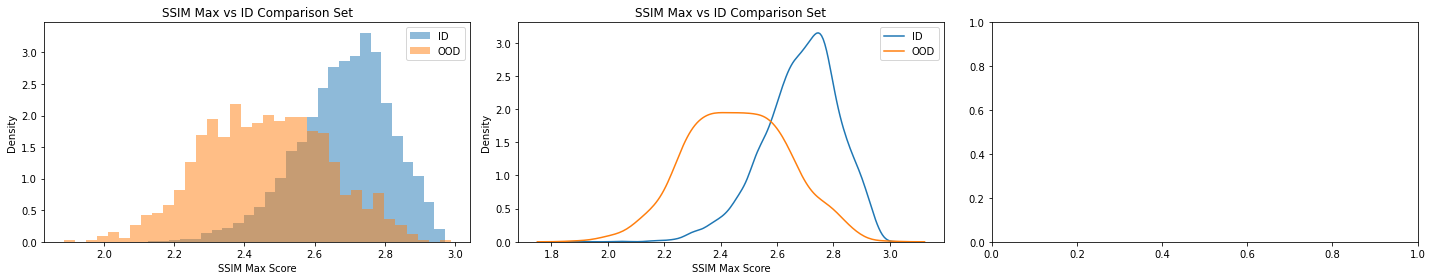

Logistic Regression Summary on SSIM Mean Values


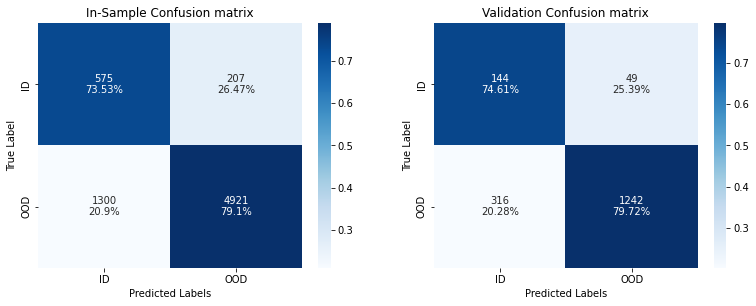

In [58]:
plot_SSIM_summary(ID_image_SSIM_scores_max, None, OOD_image_SSIM_scores_max, compute_max=False)
full_SSIM_logistic_model = logistic_regression_summary(ID_image_SSIM_scores_max, None, OOD_image_SSIM_scores_max, show_dist_overlap_table=False, return_model=True)

In [75]:
print(full_SSIM_logistic_model.coef_);print(full_SSIM_logistic_model.intercept_)

[[8.78519828]]
[-22.66904551]


#### Test Set Analysis

In [60]:
ID_images_test = [] # Create a list to hold the ID images read in as [# imgs x 256 x 256 x 3]
gc.collect()

for (input_images, _) in test_ID_ds: # Iterate on the data loader to read in images
  batch_imgs = np.stack([input_images])
  batch_imgs = batch_imgs[0,:,:,:]
  batch_imgs = batch_imgs.reshape(batch_imgs.shape[0], -1)
  ID_images_test.append(batch_imgs)

ID_images_test = np.concatenate(ID_images_test);ID_images_test=ID_images_test.reshape(-1,256,256,3);print(ID_images_test.shape) # Combine them all into 1 large np.array, [N imgs x 256x256x3]


OOD_images_test = [] # Create a list to hold the OOD images read in as [# imgs x 256 x 256 x 3]
gc.collect()

for (input_images, _) in test_OOD_ds: # Iterate on the data loader to read in images
  batch_imgs = np.stack([input_images])
  batch_imgs = batch_imgs[0,:,:,:]
  batch_imgs = batch_imgs.reshape(batch_imgs.shape[0], -1)
  OOD_images_test.append(batch_imgs)

OOD_images_test = np.concatenate(OOD_images_test);OOD_images_test=OOD_images_test.reshape(-1,256,256,3);print(OOD_images_test.shape) # Combine them all into 1 large np.array, [N imgs x 256x256x3]

(865, 256, 256, 3)
(108, 256, 256, 3)


In [61]:
# Compute mean and std dev summary metrics for each ID image
ID_images_gray_flat = ID_images_test.mean(axis=3).reshape(-1,256*256) # Reshape into [# img, 256*256] after converting to grayscale
ID_images_gray_flat_means = ID_images_gray_flat.mean(axis=1) # Compute the mean pixel value by image
print("ID_images_gray_flat_means.shape:",ID_images_gray_flat_means.shape) # Print to confirm shape

ID_images_gray_flat_sd = ID_images_gray_flat.std(axis=1) # Compute the std pixel value by image for the ID images
print("ID_images_gray_flat_sd.shape:",ID_images_gray_flat_sd.shape) # Print to confirm shape

ID_image_SSIM_scores = ssim(ID_images_gray_flat_means, ID_images_gray_flat_sd, ID_images_gray_flat,
                            ID_cluster_centroid_gray_flat_means, ID_cluster_centroid_gray_flat_sd, ID_cluster_centroid_gray_flat,
                            alpha=1,beta=1,gamma=1)

# Compute mean and std dev summary metrics for each OOD image
OOD_images_gray_flat = OOD_images_test.mean(axis=3).reshape(-1,256*256) # Reshape into [# img, 256*256] after converting to grayscale
OOD_images_gray_flat_means = OOD_images_gray_flat.mean(axis=1) # Compute the mean pixel value by image
print("OOD_images_gray_flat_means.shape:",OOD_images_gray_flat_means.shape) # Print to confirm shape

OOD_images_gray_flat_sd = OOD_images_gray_flat.std(axis=1) # Compute the std pixel value by image for the OOD images
print("OOD_images_gray_flat_sd.shape:",OOD_images_gray_flat_sd.shape) # Print to confirm shape

OOD_image_SSIM_scores = ssim(OOD_images_gray_flat_means, OOD_images_gray_flat_sd, OOD_images_gray_flat,
                            ID_cluster_centroid_gray_flat_means, ID_cluster_centroid_gray_flat_sd, ID_cluster_centroid_gray_flat,
                             alpha=1,beta=1,gamma=1)

ID_images_gray_flat_means.shape: (865,)
ID_images_gray_flat_sd.shape: (865,)
OOD_images_gray_flat_means.shape: (108,)
OOD_images_gray_flat_sd.shape: (108,)


In [62]:
ID_image_SSIM_scores_max = ID_image_SSIM_scores.max(axis=1) # Extract the row-wise max for each
OOD_image_SSIM_scores_max = OOD_image_SSIM_scores.max(axis=1) # Extract the row-wise max for each

In [65]:
# Generate predictions using the trained model
test_set_predictions = np.concatenate([full_SSIM_logistic_model.predict(ID_image_SSIM_scores_max.reshape(-1,1)),full_SSIM_logistic_model.predict(OOD_image_SSIM_scores_max.reshape(-1,1))])
test_set_true_labels = np.concatenate([np.ones(len(ID_image_SSIM_scores_max)),np.zeros(len(OOD_image_SSIM_scores_max))])
test_set_predictions_bin = (test_set_predictions>0.5)*1 # Convert to a binary 0/1 prediction

print("Test set AUC:",round(roc_auc_score(test_set_true_labels, test_set_predictions),2))
print("Test set F1 score:",round(f1_score(test_set_true_labels, test_set_predictions_bin, average='macro'),2))
print("Test set ID Accuracy:",round((test_set_true_labels[test_set_true_labels==1] == test_set_predictions_bin[test_set_true_labels==1]).mean(),3))
print("Test set OOD Accuracy:",round((test_set_true_labels[test_set_true_labels==0] == test_set_predictions_bin[test_set_true_labels==0]).mean(),3))

Test set AUC: 0.72
Test set F1 score: 0.62
Test set ID Accuracy: 0.773
Test set OOD Accuracy: 0.657


## External OOD Data Set Evaluation

#### Build External OOD Data Sets

In [8]:
from data_utils.datasets import find_image_files, build_dataset # Import functionalities from other modules

Found 20580 image files in folder "data/stanford_dogs/Images/*"


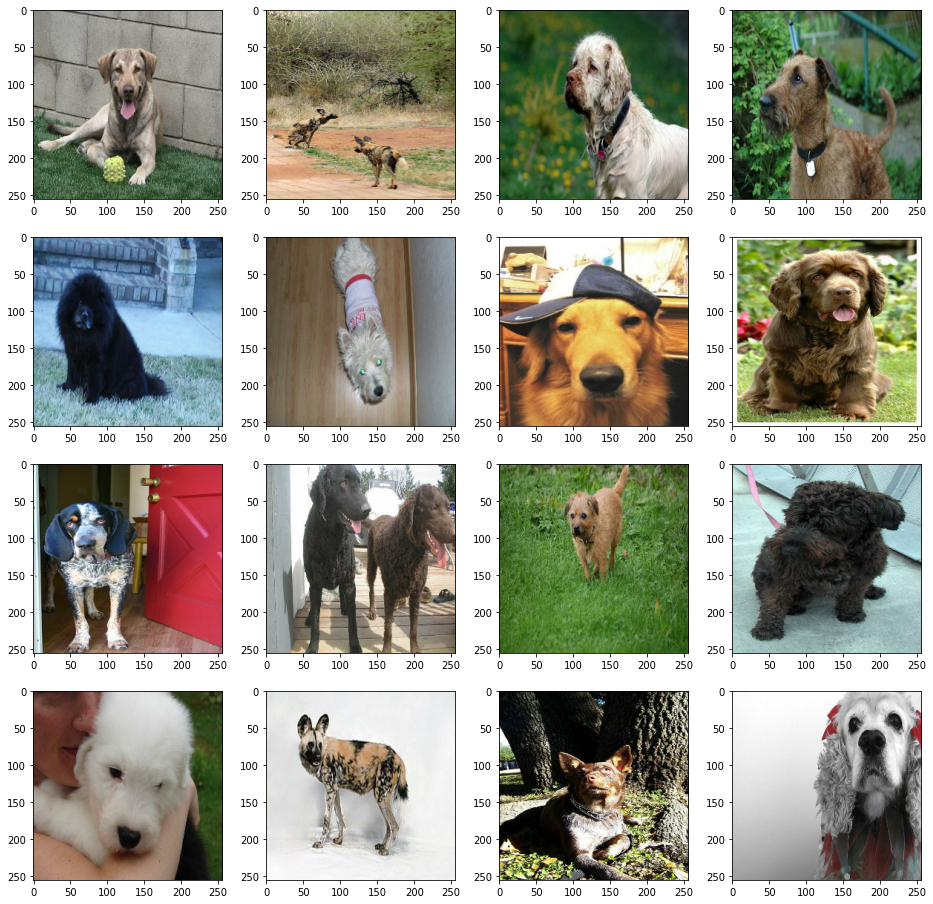

In [9]:
stanford_dogs_df = find_image_files('data/stanford_dogs/Images/*')
stanford_dogs_df = stanford_dogs_df.sample(frac=1, random_state=297) # Shuffle the data frame to get dogs of all types from top to bottom
ds_kwargs = {'cache': True, 'image_shape': (256, 256, 3), 'batch_size': 32, 'shuffle_buffer': 512} # These keyword arguments will be shared by all image datasets
stanford_dogs_ds = build_dataset(stanford_dogs_df.iloc[:3000,:], augment=False, shuffle=False, **ds_kwargs) # Use the first 3000 as a test

# Display sample images from stanford_dogs dataset
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for (input_images, target_images) in stanford_dogs_ds.take(1):
    for ax, image in zip(axes.flatten(), input_images[:16]):
        ax.imshow(image)

Found 1620 image files in folder "data/flowers102/*"


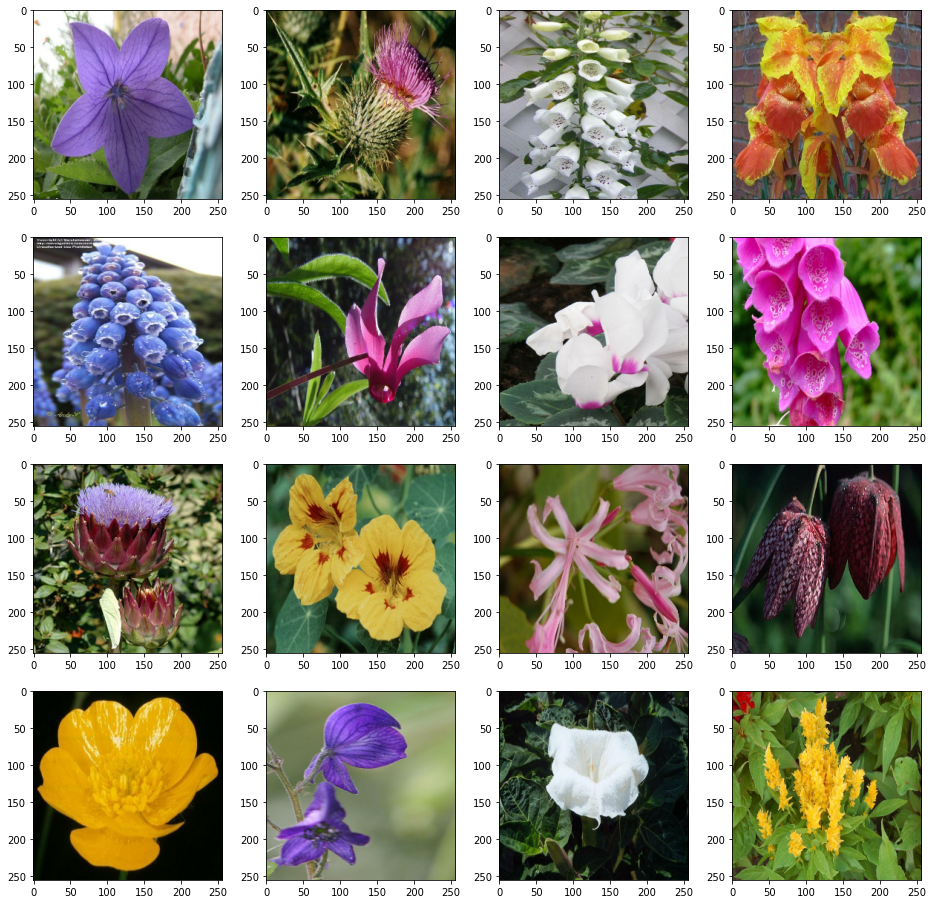

In [10]:
flowers102_df = find_image_files('data/flowers102/*')
flowers102_df = flowers102_df.sample(frac=1, random_state=297) # Shuffle the data frame to get flowers of all types from top to bottom
ds_kwargs = {'cache': True, 'image_shape': (256, 256, 3), 'batch_size': 32, 'shuffle_buffer': 512} # These keyword arguments will be shared by all image datasets
flowers102_ds = build_dataset(flowers102_df.iloc[:3000,:], augment=False, shuffle=False, **ds_kwargs) # Use the first 3000 as a test

# Display sample images from stanford_dogs dataset
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for (input_images, target_images) in flowers102_ds.take(1):
    for ax, image in zip(axes.flatten(), input_images[:16]):
        ax.imshow(image)

#### Evaluate on the test sets

In [11]:
stanford_dogs_images = [] # Create a list to hold the OOD images read in as [# imgs x 256 x 256 x 3]
gc.collect()

for (input_images, _) in stanford_dogs_ds: # Iterate on the data loader to read in images
  batch_imgs = np.stack([input_images])
  batch_imgs = batch_imgs[0,:,:,:]
  batch_imgs = batch_imgs.reshape(batch_imgs.shape[0], -1)
  stanford_dogs_images.append(batch_imgs)

stanford_dogs_images = np.concatenate(stanford_dogs_images);stanford_dogs_images=stanford_dogs_images.reshape(-1,256,256,3);print(stanford_dogs_images.shape) # Combine them all into 1 large np.array, [N imgs x 256x256x3]

(3000, 256, 256, 3)


In [12]:
flowers102_images = [] # Create a list to hold the OOD images read in as [# imgs x 256 x 256 x 3]
gc.collect()

for (input_images, _) in flowers102_ds: # Iterate on the data loader to read in images
  batch_imgs = np.stack([input_images])
  batch_imgs = batch_imgs[0,:,:,:]
  batch_imgs = batch_imgs.reshape(batch_imgs.shape[0], -1)
  flowers102_images.append(batch_imgs)

flowers102_images = np.concatenate(flowers102_images);flowers102_images=flowers102_images.reshape(-1,256,256,3);print(flowers102_images.shape) # Combine them all into 1 large np.array, [N imgs x 256x256x3]

(1620, 256, 256, 3)


In [17]:
stanford_dogs_ssim_array_cc = np.zeros([len(stanford_dogs_images),len(ID_cluster_centroids)]);flowers_ssim_array_cc = np.zeros([len(flowers102_images),len(ID_cluster_centroids)])

for j,comp_img in enumerate(tqdm(ID_cluster_centroids)):
  stanford_dogs_ssim_array_cc[:,j] = tf.image.ssim(stanford_dogs_images, comp_img, 1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03).numpy()
  flowers_ssim_array_cc[:,j] = tf.image.ssim(flowers102_images, comp_img, 1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


In [18]:
stanford_dogs_ssim_max = stanford_dogs_ssim_array_cc.max(axis=1);flowers_ssim_max = flowers_ssim_array_cc.max(axis=1)

In [28]:
# Generate y_pred fitted values for OOD analysis using the best logistic model
stanford_dogs_pred_probs=SSIM_logistic_model.predict_proba(stanford_dogs_ssim_max.reshape(-1,1))[:,1]
flowers_pred_probs=SSIM_logistic_model.predict_proba(flowers_ssim_max.reshape(-1,1))[:,1] 

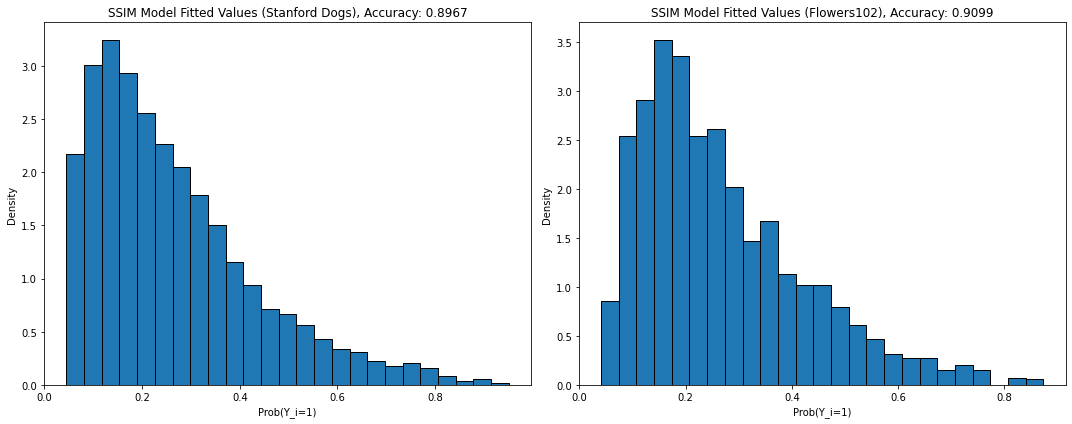

In [29]:
fig,axes = plt.subplots(1,2,figsize=(15,6))

axes[0].set_title("SSIM Model Fitted Values (Stanford Dogs), Accuracy: "+str(round(((stanford_dogs_pred_probs<0.5)*1).mean(),4)))
axes[0].set_ylabel("Density");axes[0].set_xlabel("Prob(Y_i=1)");axes[0].hist(stanford_dogs_pred_probs,edgecolor='black',bins=25,density=True)

axes[1].set_title("SSIM Model Fitted Values (Flowers102), Accuracy: "+str(round(((flowers_pred_probs<0.5)*1).mean(),4)))
axes[1].set_ylabel("Density");axes[1].set_xlabel("Prob(Y_i=1)");axes[1].hist(flowers_pred_probs,edgecolor='black',bins=25,density=True)
plt.tight_layout();plt.show()